# Playing with learning MMM
Based on https://github.com/zaai-ai/lab/blob/main/marketing/MMM/MMM.ipynb

Using methods from https://github.com/mkelk/BookCode_Edition1_me

In [33]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats
from scipy.stats import entropy
from scipy.optimize import minimize
import pandas as pd
import datetime
import seaborn as sns

import utils
from utils import MyModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(521)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Load example data and do a bit of engineering
https://www.kaggle.com/datasets/yasserh/advertising-sales-dataset/code

In [4]:
df = pd.read_csv('data/Advertising Budget and Sales.csv')
df = df.rename(columns={'Unnamed: 0': 'id', 'TV Ad Budget ($)':'tv', 'Radio Ad Budget ($)': 'radio', 'Newspaper Ad Budget ($)': 'newspaper', 'Sales ($)': 'sales'})
df['ds'] = df['id'].apply(lambda x: pd.to_datetime("2024-02-26")-datetime.timedelta(weeks=len(df)-x))
df

id     tv  radio  newspaper  sales         ds
0      1  230.1   37.8       69.2   22.1 2020-05-04
1      2   44.5   39.3       45.1   10.4 2020-05-11
2      3   17.2   45.9       69.3    9.3 2020-05-18
3      4  151.5   41.3       58.5   18.5 2020-05-25
4      5  180.8   10.8       58.4   12.9 2020-06-01
..   ...    ...    ...        ...    ...        ...
195  196   38.2    3.7       13.8    7.6 2024-01-29
196  197   94.2    4.9        8.1    9.7 2024-02-05
197  198  177.0    9.3        6.4   12.8 2024-02-12
198  199  283.6   42.0       66.2   25.5 2024-02-19
199  200  232.1    8.6        8.7   13.4 2024-02-26

[200 rows x 6 columns]

# Initiate my MMM model

In [36]:
mymodel = MyModel(df, targetvar='sales', timevar="dt", features=['tv', 'radio', 'newspaper'])

# Exploratory analysis

### Sales over time

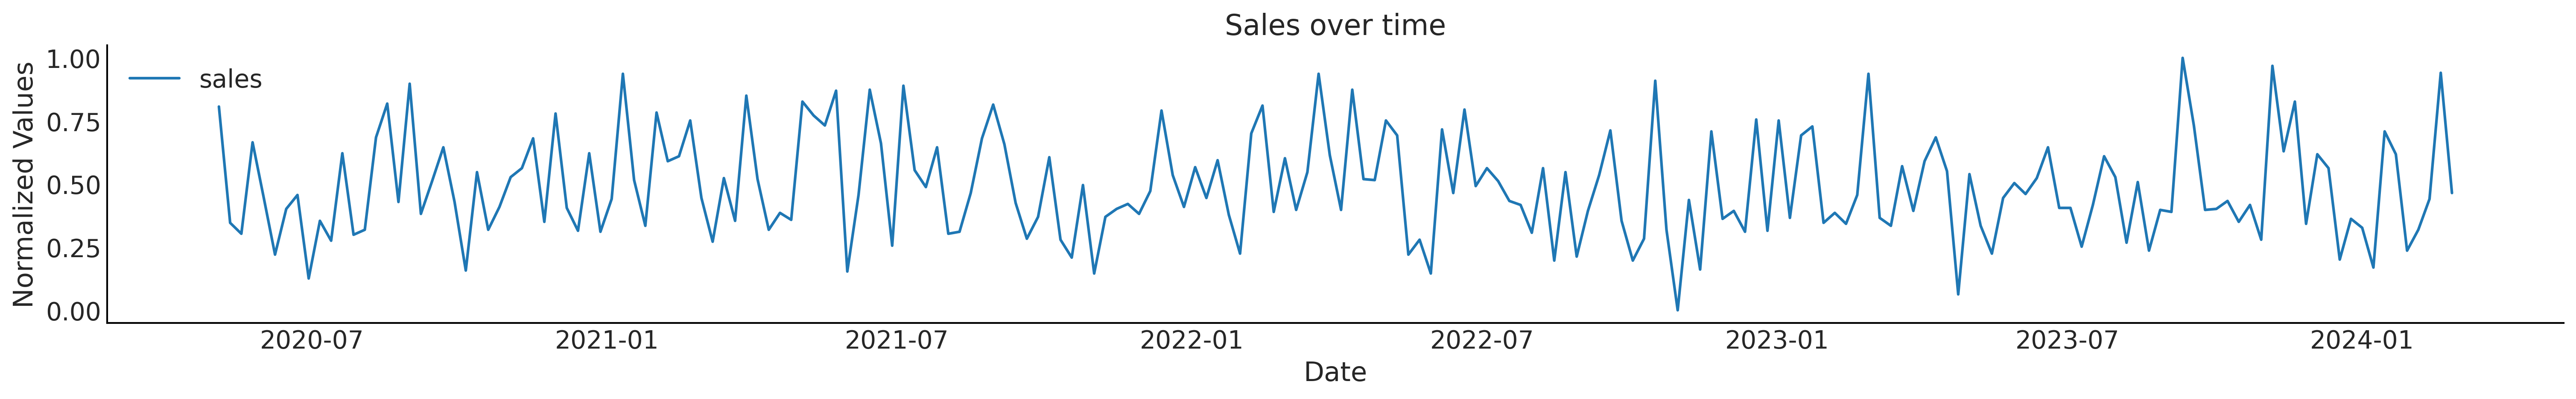

In [37]:
mymodel.line_plot_general(['sales'], "Sales over time")

### Channel spend

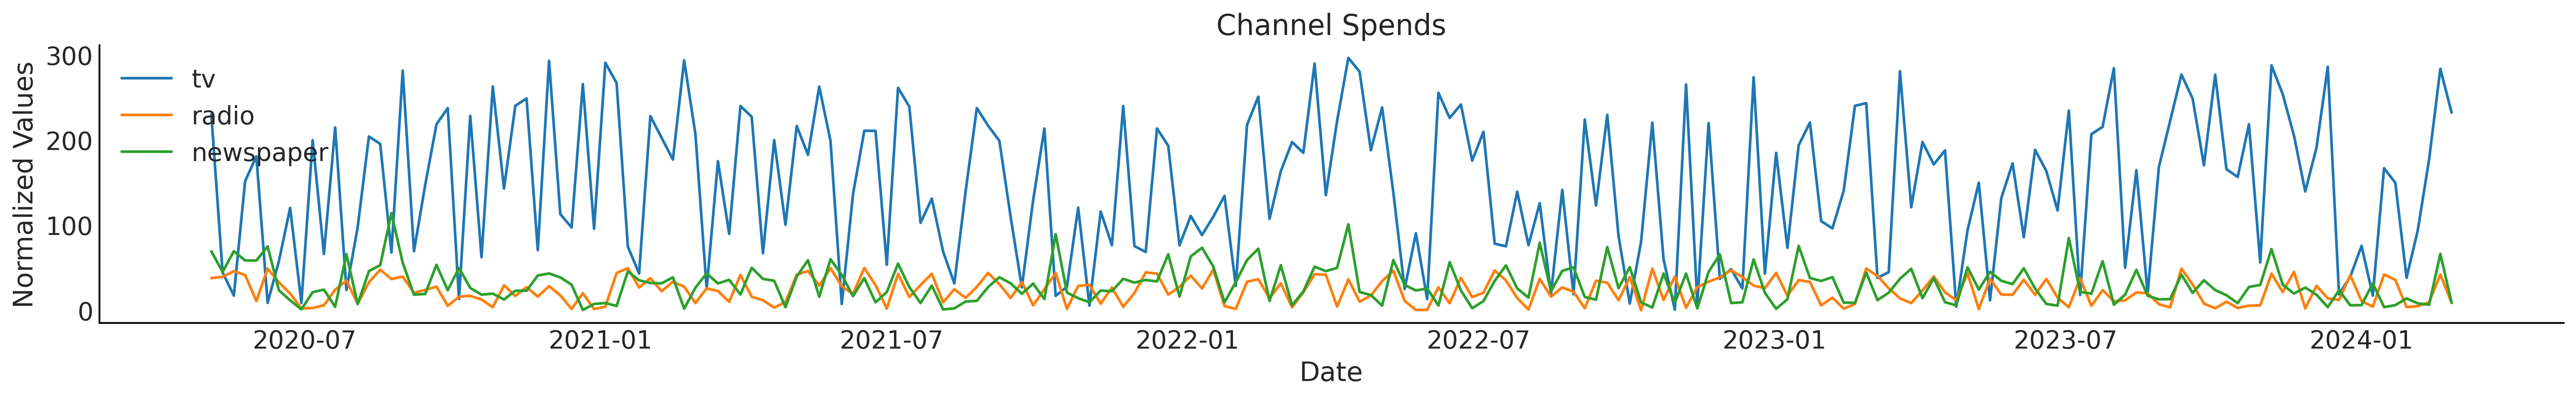

In [39]:
mymodel.plot_channel_spends()

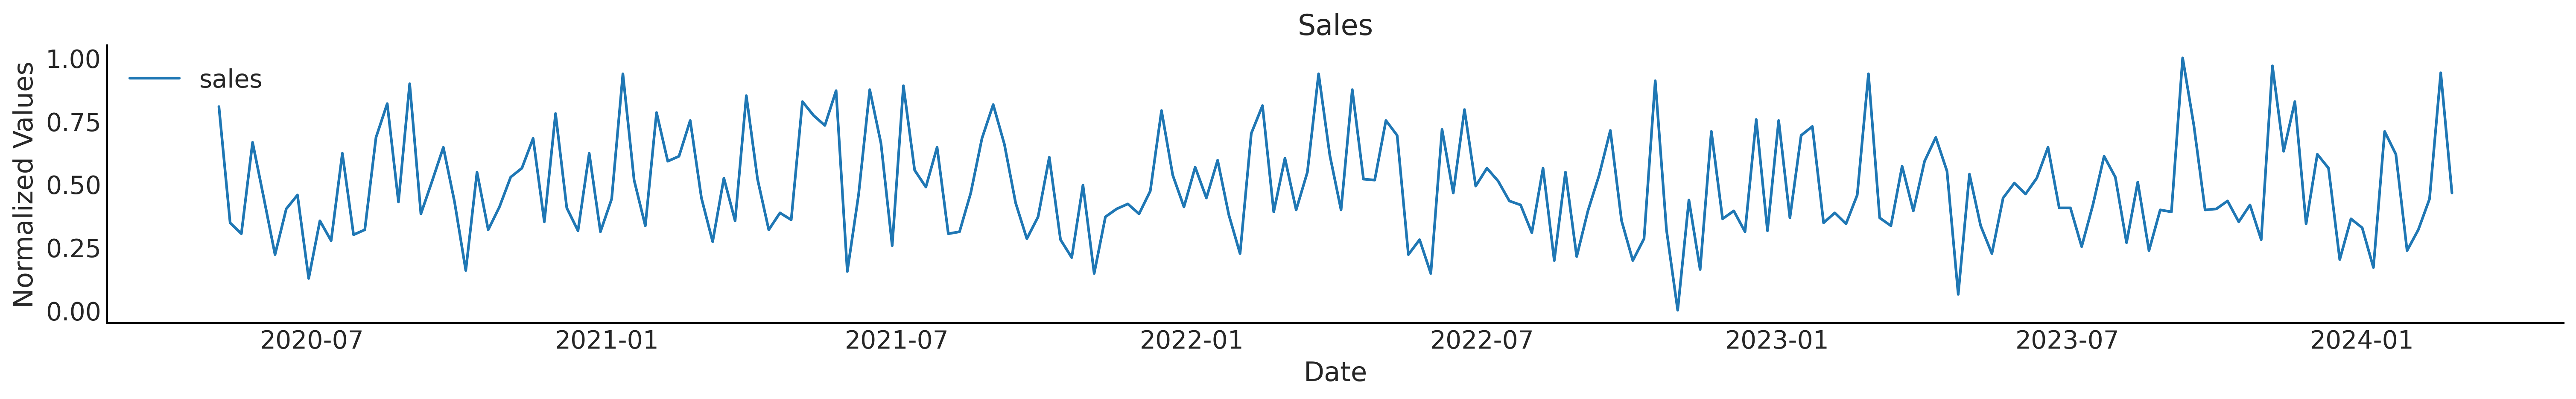

In [40]:
mymodel.plot_sales()

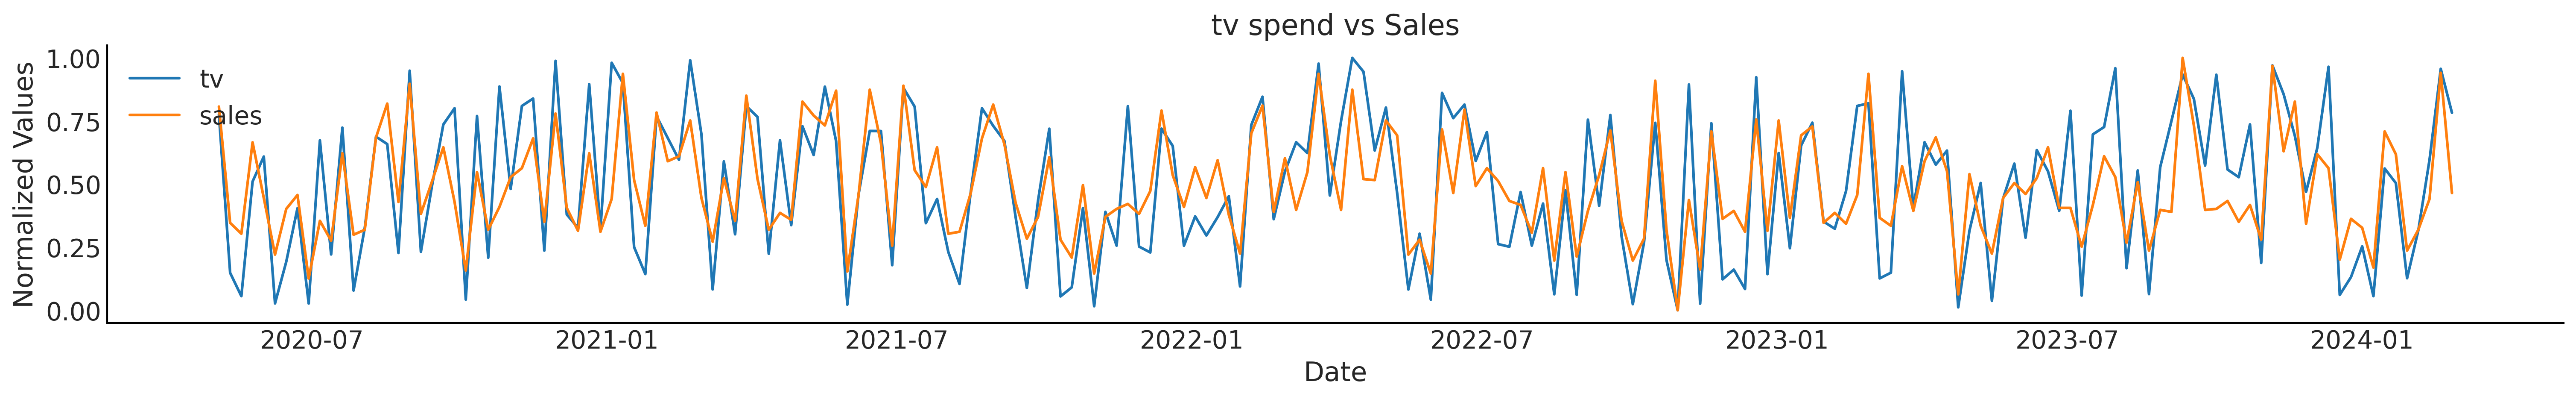

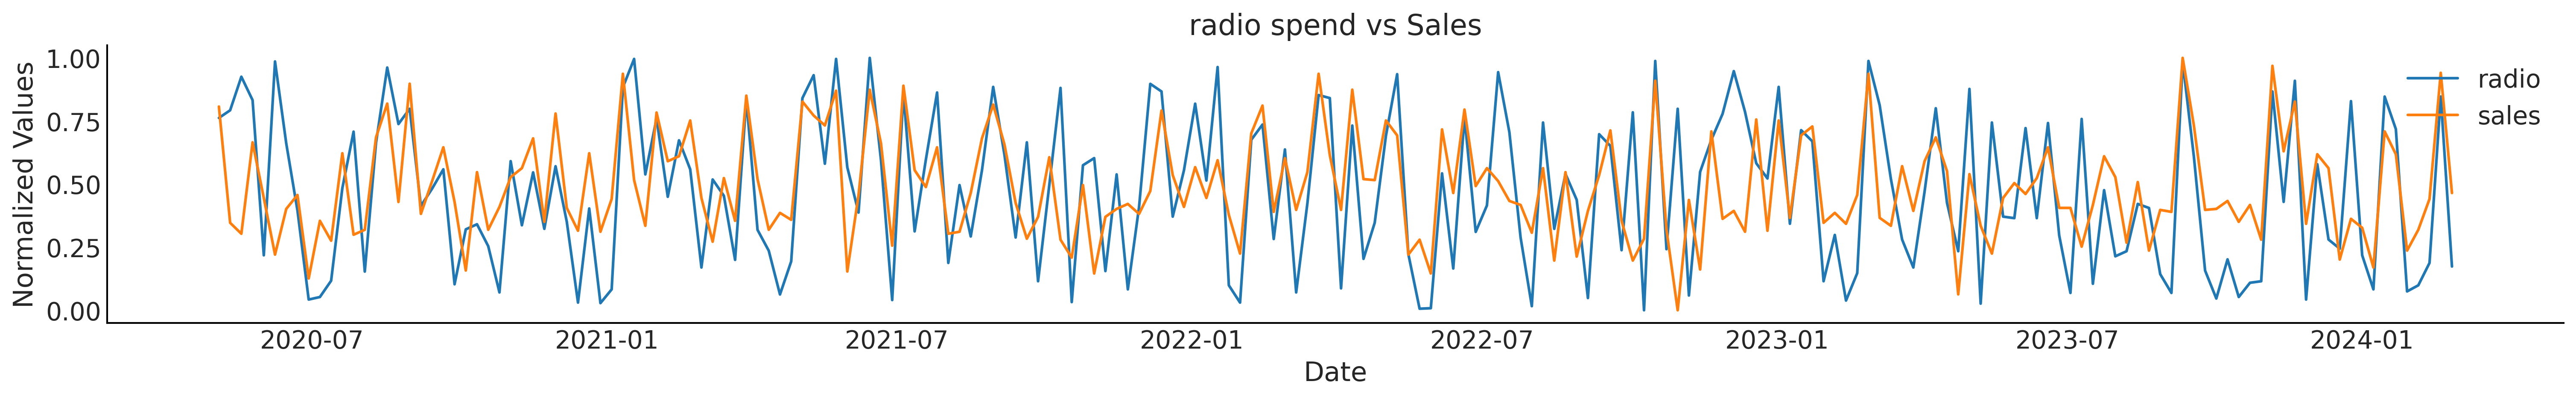

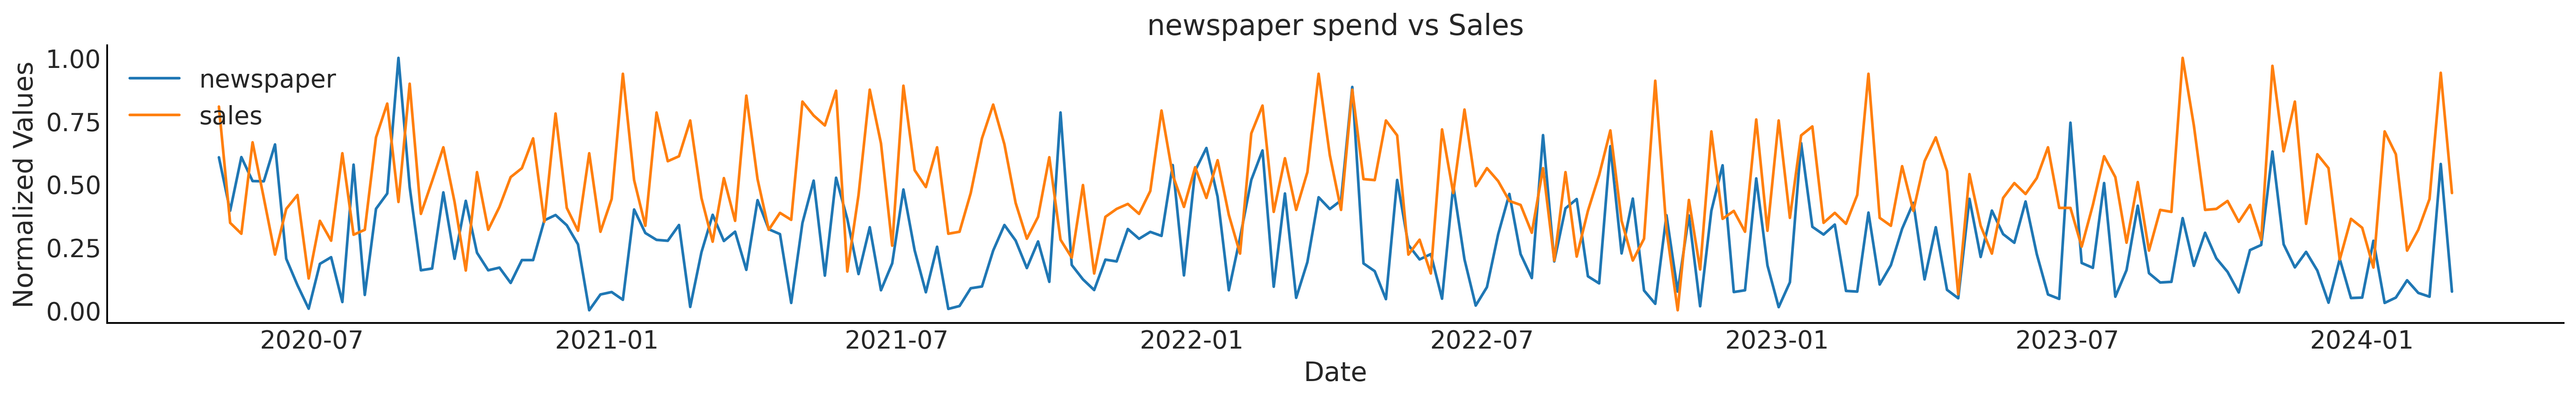

In [43]:
mymodel.plot_channel_spends_vs_sales()

### Correlation between variables

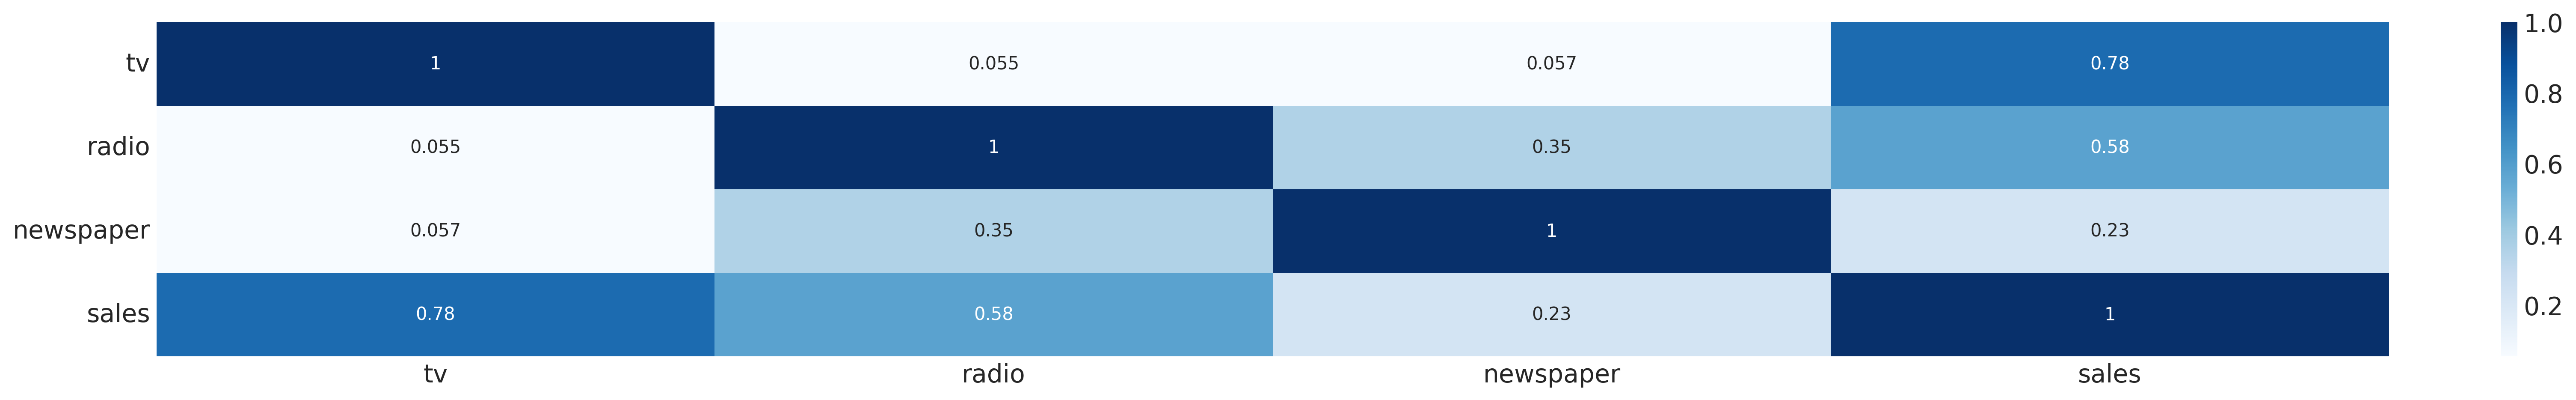

In [44]:
mymodel.plot_correlation_matrix()

# Simple example: Sales as a normal distribution independent of any input

### First some exploration

Get the average and standard deviation of the sales data.m

In [10]:
# average and sqrt(var) of sales
y = df['sales'].values
y_mean = y.mean()
y_var = y.var() ** 0.5
(y_mean, y_var)


(14.0225, 5.204396578855228)

In [11]:
# average of tv and ratio to sales
tv_obs = df['tv'].values
tv_mean = tv_obs.mean()
tv_mean, y_mean / tv_mean

(147.0425, 0.09536358535797475)


### Declare a model in PyMC3

In [12]:
with pm.Model() as model:
    # control variables
    spend_tv = df['tv'].values

    # PRIORS for unknown model parameters
    # intercept gets a prior here
    beta_i = pm.Normal("beta_i", mu=4, sigma=1, initval=1)

    # tv gets a prior here
    beta_tv = pm.Normal("beta_tv", mu=0.1, sigma=0.1)

    # sigma for the model gets a prior here
    sigma = pm.HalfNormal("sigma", sigma=1)

    y_obs = pm.Normal("y_obs", mu=beta_i + beta_tv * spend_tv, sigma=sigma, observed=df['sales'])

    # Sample from the posterior distribution (and have some prior sampling here, too)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [beta_i, beta_tv, sigma, y_obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_i, beta_tv, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_obs]


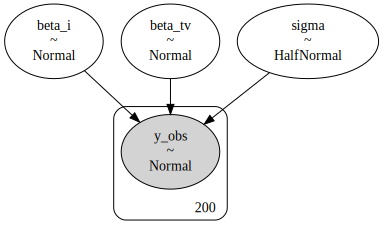

In [13]:
graphviz = pm.model_to_graphviz(model)
graphviz

### Chains and traces
Show distribution of the model parameters seen in the chains

array([[<Axes: title={'center': 'beta_i'}>,
        <Axes: title={'center': 'beta_i'}>],
       [<Axes: title={'center': 'beta_tv'}>,
        <Axes: title={'center': 'beta_tv'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

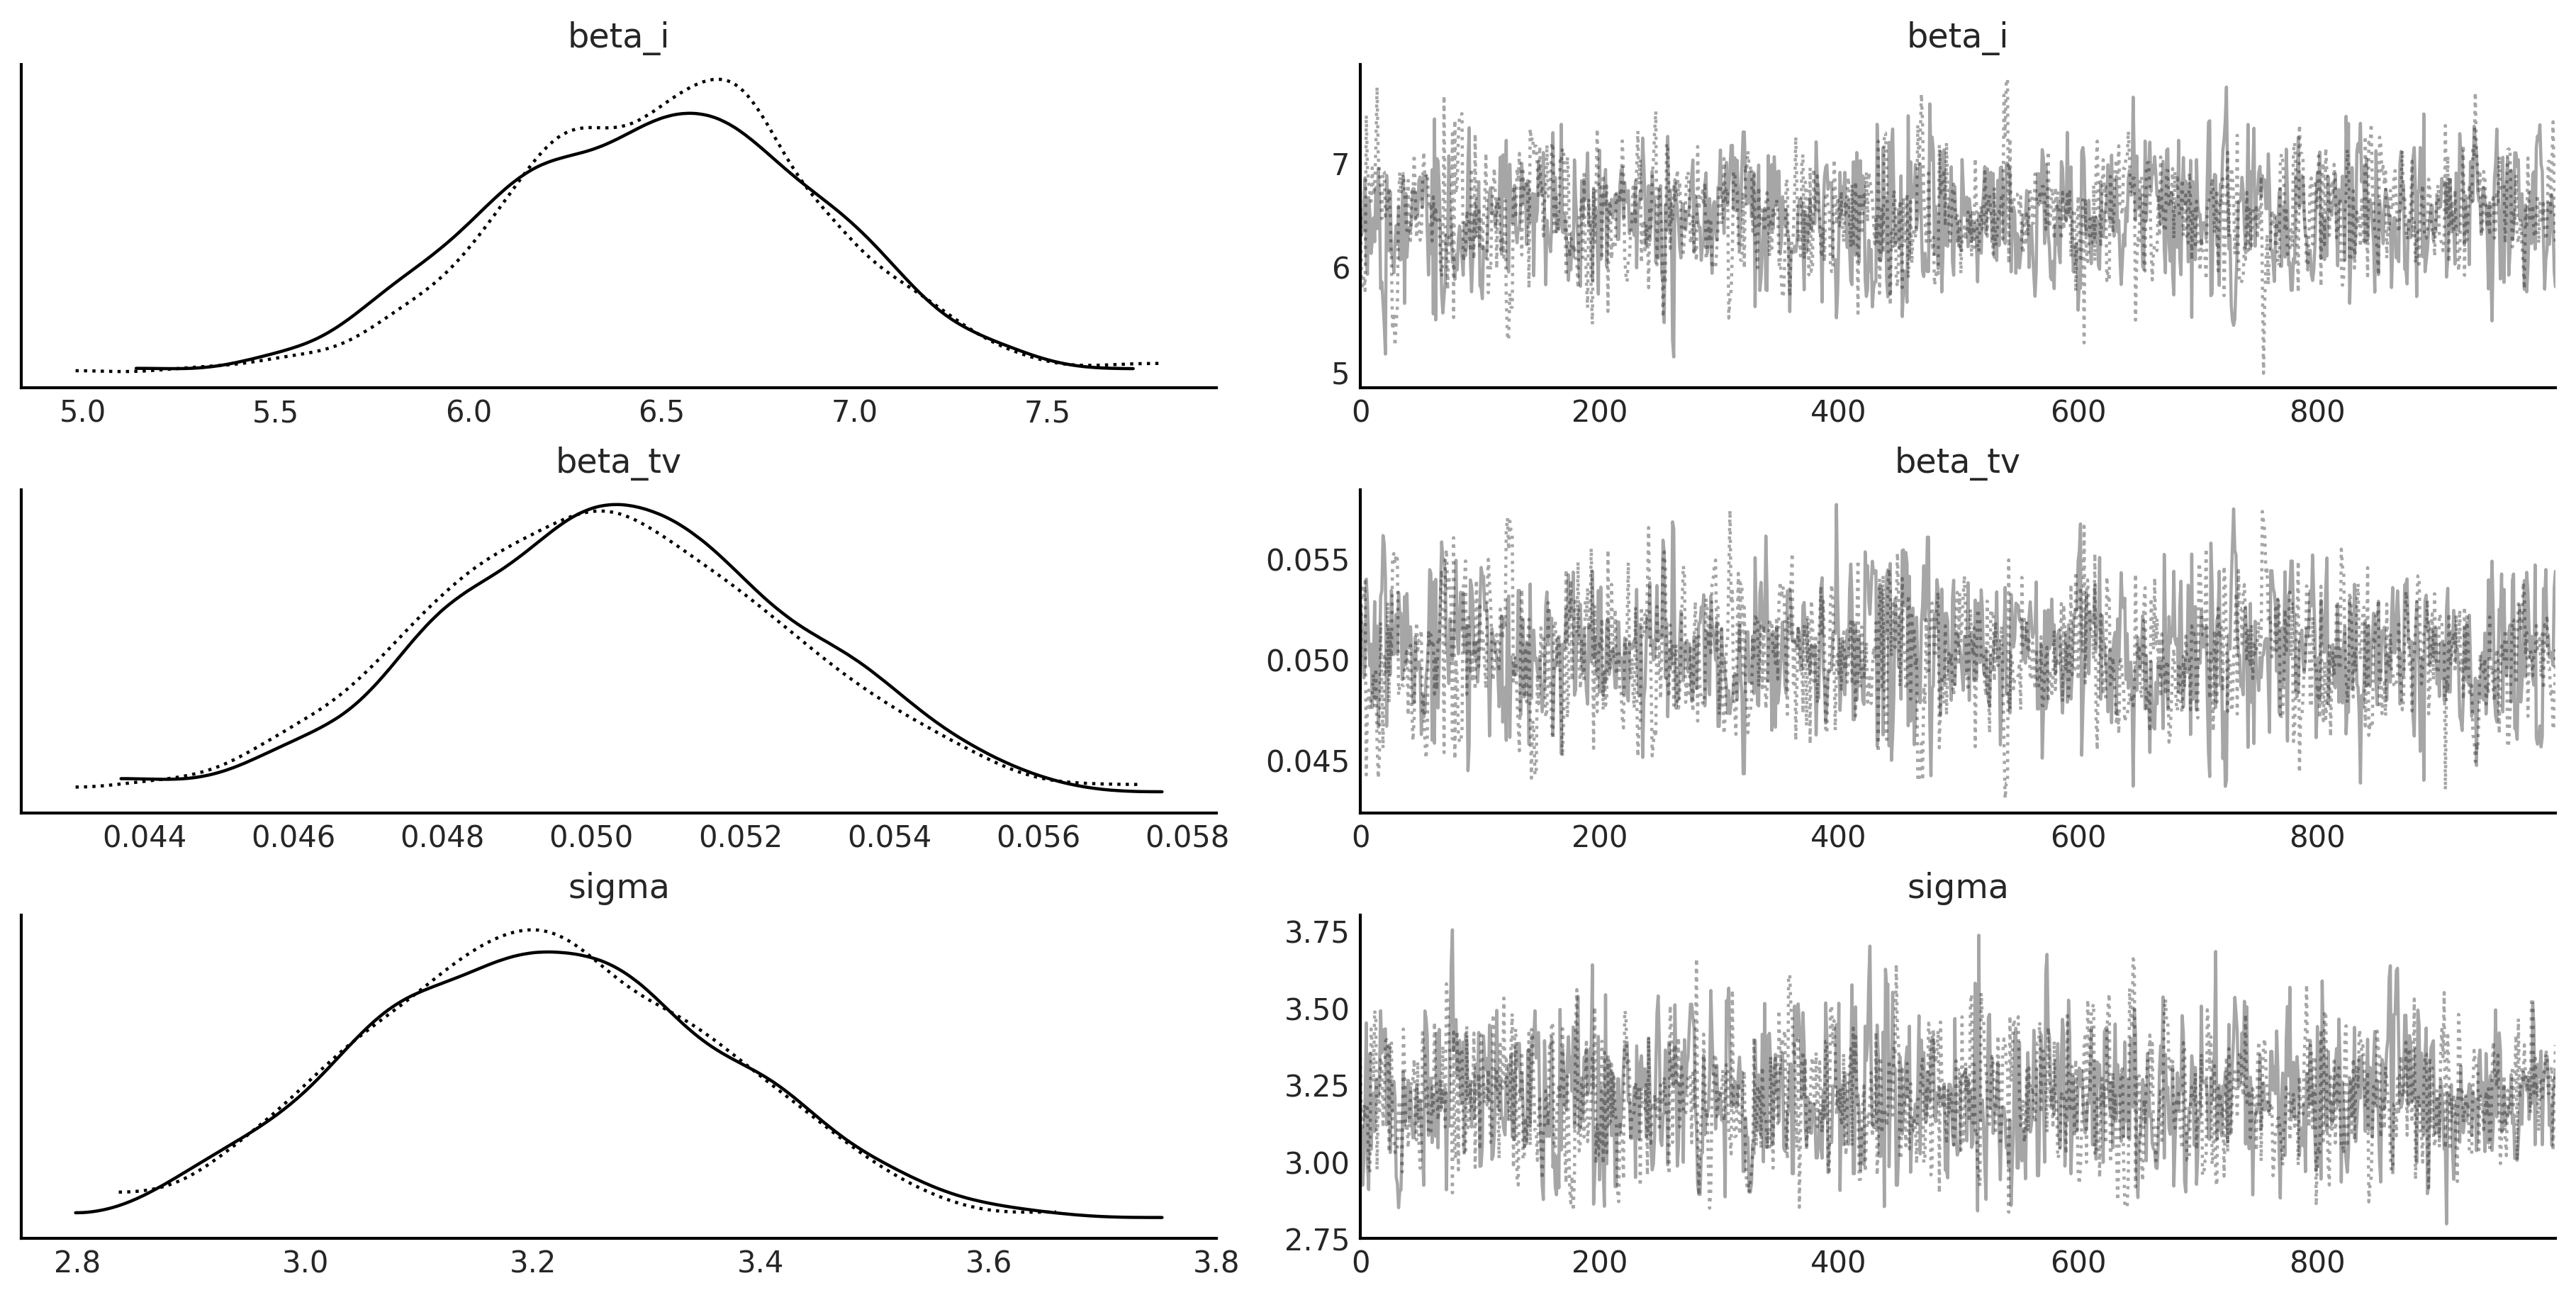

In [14]:
az.plot_trace(idata)

# Prior and posterior distributions

In [15]:
az.plot_dist_comparison(idata)

array([[<Axes: >, <Axes: >, <Axes: xlabel='beta_i'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='beta_tv'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='sigma'>]], dtype=object)

# Understanding the quantities we can get from the modeling

Sampling: [beta_i, beta_tv, sigma, y_obs]


<Axes: >

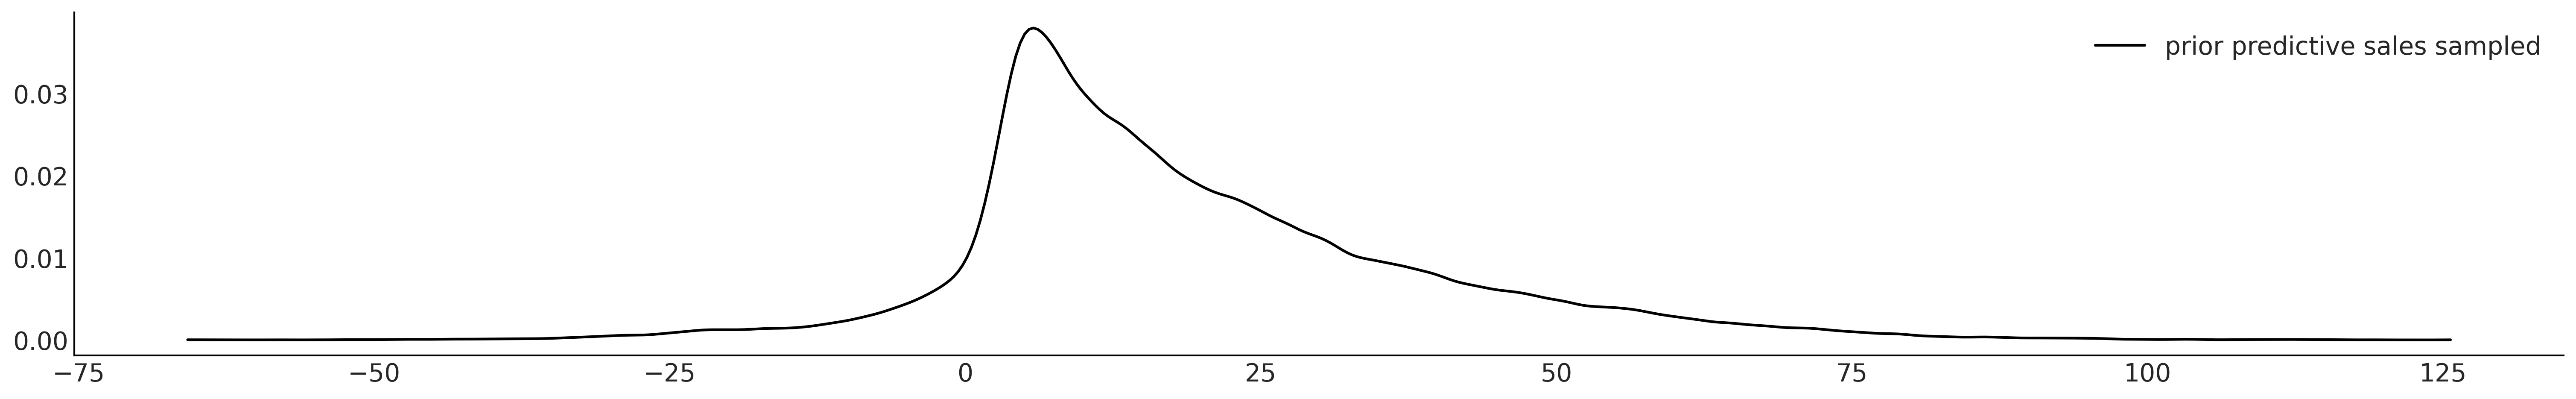

In [16]:
# 500 samples of y_obs generated from the prior predictive distribution
# Remember: 1 observation is 200 data-points, since there are 200 weeks in the dataset
prior_pred_y_obs = pm.sample_prior_predictive(500, model).prior_predictive["y_obs"].values
az.plot_dist(prior_pred_y_obs.mean(axis=0), label="prior predictive sales sampled")


In [17]:
# here are samples of the posterior predictives on parameters and y_obs
pm.sample_posterior_predictive(idata, model).posterior_predictive

Sampling: [y_obs]


<xarray.Dataset>
Dimensions:      (chain: 2, draw: 1000, y_obs_dim_2: 200)
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_obs_dim_2  (y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y_obs        (chain, draw, y_obs_dim_2) float64 16.1 8.472 ... 22.94 22.38
Attributes:
    created_at:                 2024-06-10T15:15:36.953530
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.2

<Axes: >

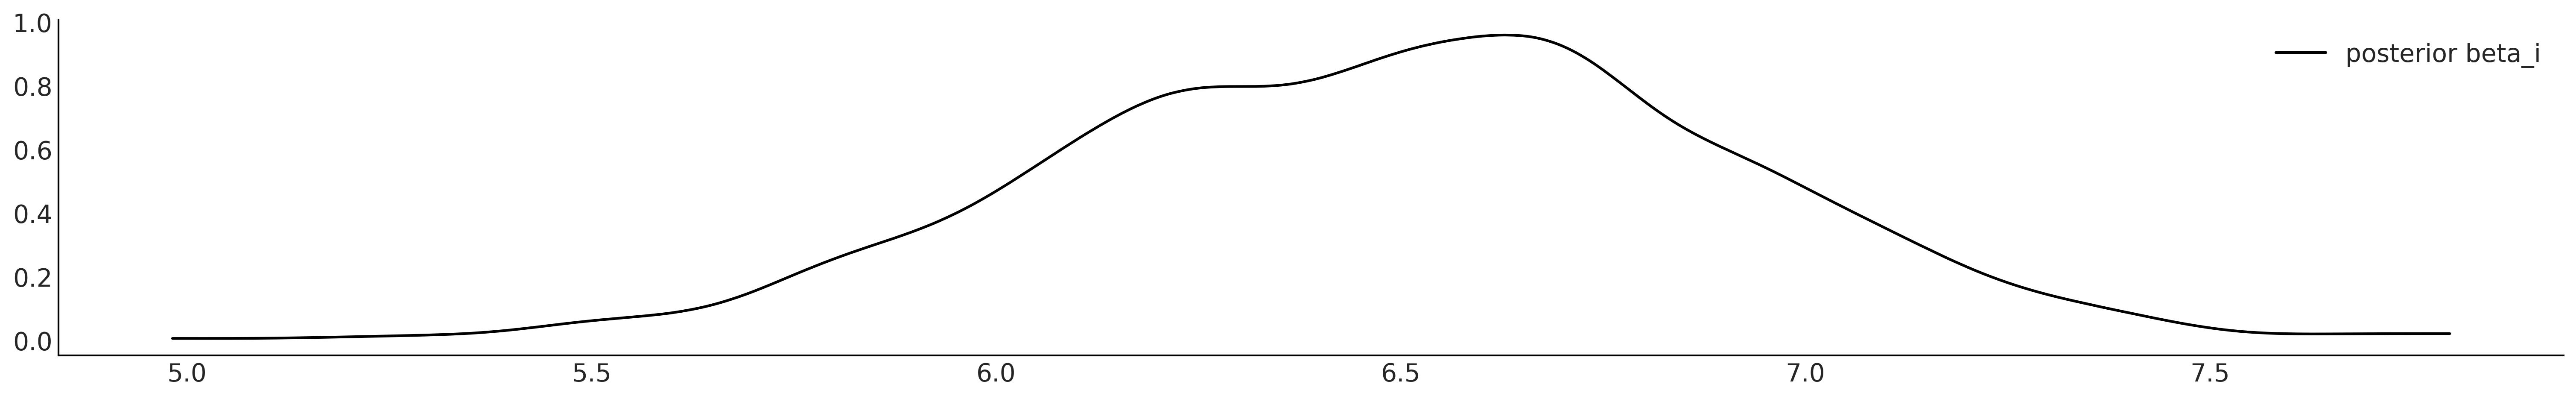

In [18]:
# plot the posterior predictive distribution of beta_tv
az.plot_dist(idata.posterior["beta_i"], label="posterior beta_i")

In [19]:
# the samples of y_obs generated from the posterior predictive distribution
# each chain link has a full obs of 200 points (the incoming vector of 200 weeks that we model)
# there are X chains, each with Y steps
post_pred_y_obs =  pm.sample_posterior_predictive(idata, model).posterior_predictive["y_obs"].values
post_pred_y_obs.shape

Sampling: [y_obs]


(2, 1000, 200)

In [28]:
means = post_pred_y_obs.mean(axis=(0,1))
means.shape
X = df['ds'].values
X
Yorg = df['sales'].values

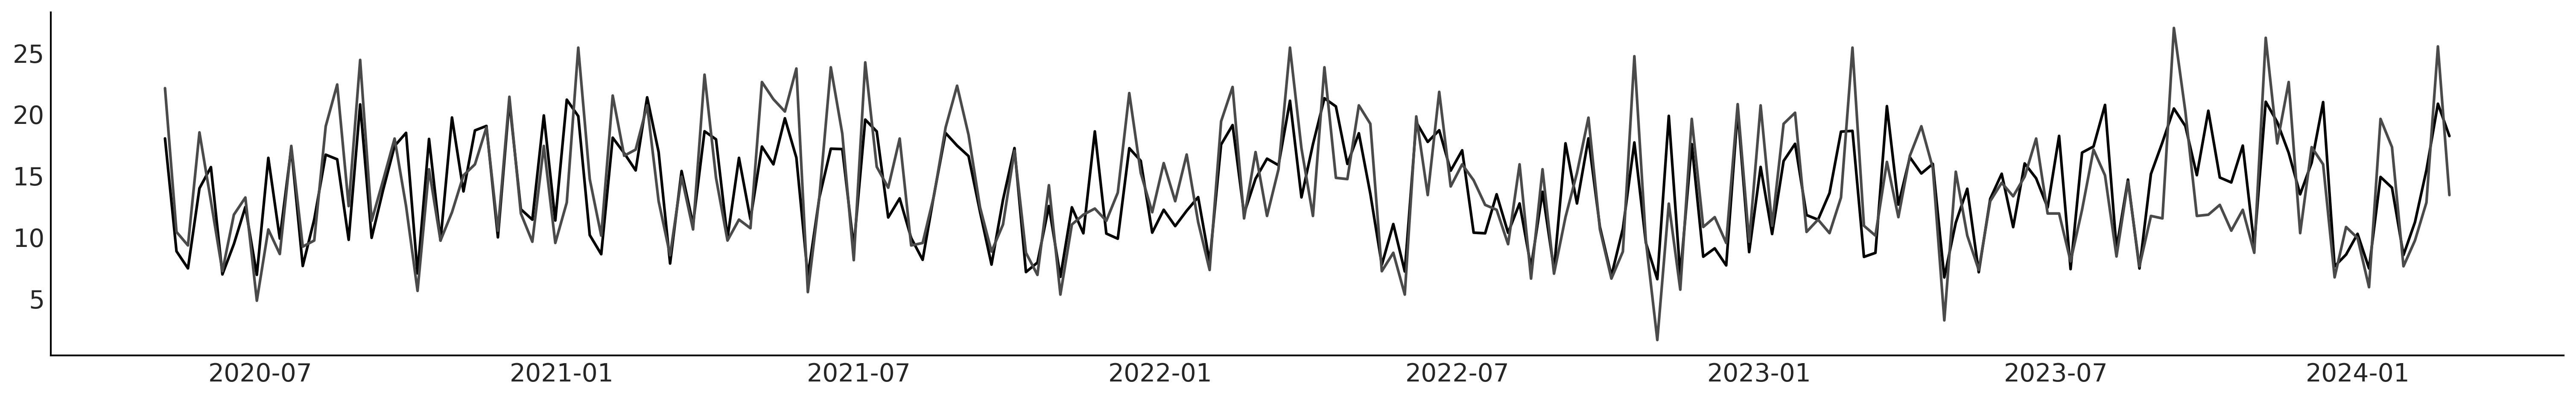

In [31]:
fig, ax = plt.subplots()
ax.plot(
    X,
    means,
    label="posterior predictive sales sampled")
ax.plot(
    X,
    Yorg,
    label="original sales")
